In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# number of rows and columns in the chessboard
crows = 9
ccols = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ccols*crows,3), np.float32)
print (objp.shape)

mesh = np.mgrid[0:crows, 0:ccols]
meshT = mesh.T
# assign x-y co-ordinates
objp[:,:2] = meshT.reshape(-1,2)

(54, 3)


In [2]:
import matplotlib.image as mpimg

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
image_save_dir = 'output_images'
# Step through the list and search for chessboard cor(objp)ners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (crows,ccols), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (crows,ccols), corners, ret)
        write_name = '/'.join([image_save_dir, 'corners_found'+str(idx)+'.jpg'])
        
        mpimg.imsave(write_name, img)

In [3]:
# Calibrate camera
import random 

idx = random.randint(0, len(images) - 1)
img = mpimg.imread(images[idx])
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

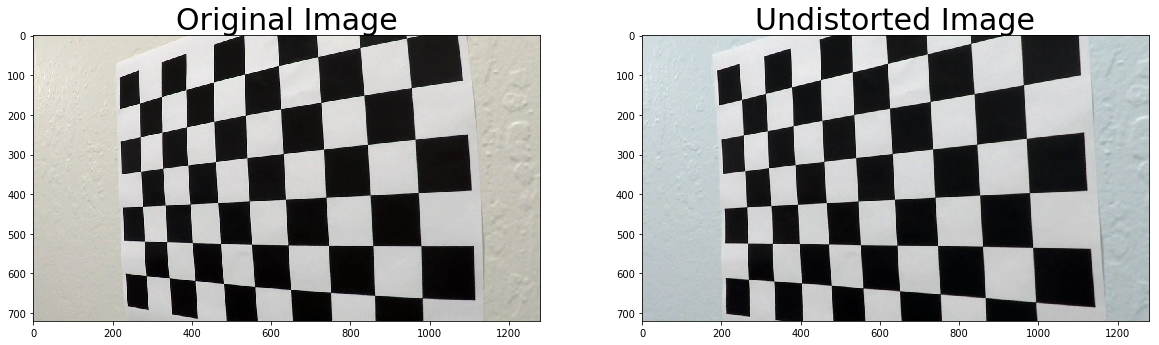

In [4]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = '/'.join([image_save_dir, 'undistored'+str(idx)+'.jpg'])
    mpimg.imsave(write_name,dst)

# sample visualization of an undistored image
idx = random.randint(0, len(images) - 1)
fname = '/'.join([image_save_dir, 'undistored'+str(idx)+'.jpg'])
test = mpimg.imread(fname)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

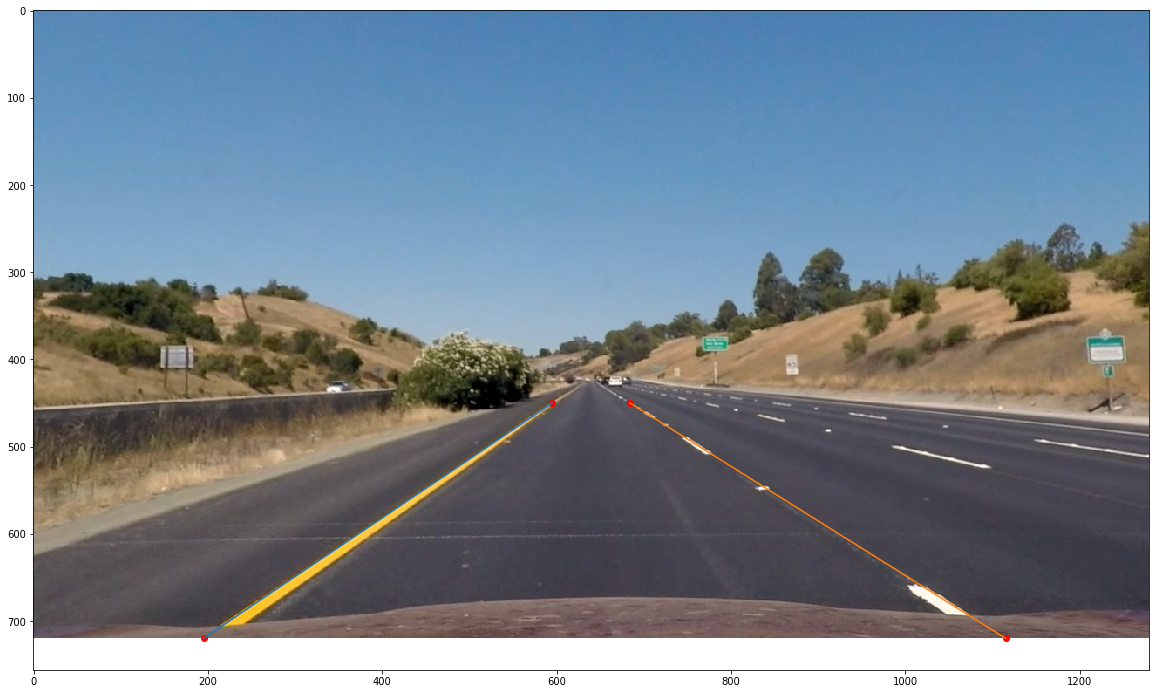

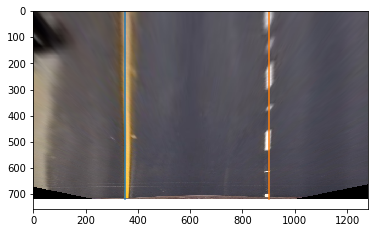

In [5]:
straight_image = mpimg.imread('test_images/straight_lines1.jpg')
straight_image = cv2.undistort(straight_image, mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.imshow(straight_image)

plt.plot(595, 450, 'ro')
plt.plot(684, 450, 'ro')
plt.plot(1115, 720, 'ro')
plt.plot(195, 720, 'ro')

plt.plot((195, 595), (720, 450))
plt.plot((1115, 684), (720, 450))

src = np.float32([[595, 450], [684, 450], [1115, 720], [195, 720]])
dst = np.float32([[350, 0], [900, 0], [900, 720], [350, 720]])

M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(straight_image, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(warped)
plt.plot((350, 350), (0,720))
plt.plot((900, 900), (0,720))

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x = 0
    y = 0
    if orient == 'x':
        x = 1
    else:
        y=1
    sob = cv2.Sobel(gray, cv2.CV_64F, x,y)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sob)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255.0 * (abs_sobel/np.max(abs_sobel)))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros(scaled_sobel.shape)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1 
    # 6) Return this mask as your binary_output image

    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F,1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F,0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt((sobel_x ** 2) + (sobel_y ** 2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scaled = np.uint8(255.0 * (sobel_mag/np.max(sobel_mag)))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros(sobel_scaled.shape)
    binary_output[(sobel_scaled > mag_thresh[0]) & (sobel_scaled < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


In [9]:
# run the pipeline for each test image
test_images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=3, thresh=(30, 100))
    grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=3, thresh=(30, 100))
    mag_binary = mag_thresh(dst, sobel_kernel=9, mag_thresh=(50, 150))
    dir_binary = dir_threshold(dst, sobel_kernel=15, thresh=(0.7, 1.3))
    
    hls_binary = hls_select(dst, thresh=(160, 255))
    
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined_grad)
    combined_binary[(combined_grad == 1) | (hls_binary == 1)] = 1

    write_name = '/'.join([image_save_dir, 'threshold'+str(idx)+'.jpg'])
    mpimg.imsave(write_name, combined_binary)
    
    warped_binary = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    write_name = '/'.join([image_save_dir, 'warped'+str(idx)+'.jpg'])
    mpimg.imsave(write_name, warped_binary)
    
    do_plotting = 0 #random.randint(0,1)

    if do_plotting:
        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = np.dstack(( np.zeros_like(combined_grad), combined_grad, hls_binary))

        # Plotting thresholded images
        plt.figure()
        f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20,10))
        ax1.set_title('Undistored Image')
        ax1.imshow(dst)
        ax2.set_title('Stacked thresholds')
        ax2.imshow(color_binary)

        ax3.set_title('Combined S channel and gradient thresholds')
        ax3.imshow(combined_binary, cmap='gray')
        
        ax4.set_title('Warped Binary Image')
        ax4.imshow(warped_binary, cmap='gray')
    

In [8]:
# warp all test images
